In [11]:
# Connect to Elastic Cloud
from elasticsearch import Elasticsearch
import urllib3
urllib3.disable_warnings()


es = Elasticsearch(
    ['https://86dd17d952698a0f90485f28a0087669.eu-west-1.aws.found.io'],
    port=9243,
    http_auth='elastic:9X4hmUZXasOBuF49ujcGBqLS',
    verify_certs=False
)

es.cluster.health()


{u'active_primary_shards': 5,
 u'active_shards': 10,
 u'active_shards_percent_as_number': 100.0,
 u'cluster_name': u'86dd17d952698a0f90485f28a0087669',
 u'delayed_unassigned_shards': 0,
 u'initializing_shards': 0,
 u'number_of_data_nodes': 2,
 u'number_of_in_flight_fetch': 0,
 u'number_of_nodes': 3,
 u'number_of_pending_tasks': 0,
 u'relocating_shards': 0,
 u'status': u'green',
 u'task_max_waiting_in_queue_millis': 0,
 u'timed_out': False,
 u'unassigned_shards': 0}

In [15]:
# Prepare for uuid, data_centres, event_types, timestamp
import uuid
str(uuid.uuid4())

data_centres = ["data centre a",
                "data centre b",
                "data centre c",
                "data centre d",
                "data centre e"]

event_types = ["transfer-queued", "transfer-success", "transfer-failed"]

import datetime
datetime.datetime.now().replace(microsecond=0).isoformat()

#event={}

'2017-03-12T21:58:53'

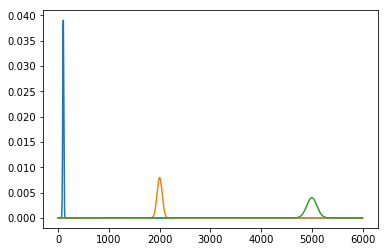

In [18]:
# Look for a good distribution of file size
import numpy as np
from scipy.stats import norm
import random
mu1, sigma1=100, 10     # 100MB
mu2, sigma2=2000, 50    # 2GB
mu3, sigma3=5000, 100    # 5GB
dist1 = norm(mu1, sigma1)
dist2 = norm(mu2, sigma2)
dist3 = norm(mu3, sigma3)


#random.gauss(mu1, sigma1)

#s = np.random.normal(mu1, sigma1, 1000)
#s = np.random.normal(mu2, sigma2, 1000)
#s = np.random.normal(mu3, sigma3, 1000)
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

x = np.linspace(0, 6000, 1000)
plt.plot(x, dist1.pdf(x))
plt.plot(x, dist2.pdf(x))
plt.plot(x, dist3.pdf(x))
plt.show()

In [102]:
# utilities functions for create event

import random
import uuid
import datetime
import copy
from __future__ import print_function
# Connect to Elastic Cloud
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import urllib3
urllib3.disable_warnings()



es = Elasticsearch(
    ['https://86dd17d952698a0f90485f28a0087669.eu-west-1.aws.found.io'],
    port=9243,
    http_auth='elastic:9X4hmUZXasOBuF49ujcGBqLS',
    verify_certs=False
)


event_types = ["transfer-queued", "transfer-success", "transfer-failed"]
data_centres = ["data centre a",
                "data centre b",
                "data centre c",
                "data centre d",
                "data centre e"]


# 95% succeed, 5% failures
def generate_event_types():
    if random.random() <= 0.95:
        return event_types[1]
    else:
        return event_types[2]
    
# UUID4
def generate_uuid():
    return uuid.uuid4()

# randon file size based on guassians around 100MB, 2GB, 5GB
def generate_file_size():
    randSizeCentroid = random.random()
    mu, sigma=0, 0.5
    
    # Around 100MB
    if randSizeCentroid < 0.333:
        mu, sigma=100, 10
    # Around 2GB
    elif randSizeCentroid < 0.666:
        mu, sigma=2000, 50
    # Around 5GB
    else:
        mu, sigma=5000, 100
    
    size = random.gauss(mu, sigma)
    while size <= 0 and size >=10000:
        size = random.gauss(mu, sigma)
    
    return int(size * 1000000) # convert into bytes

# generate start timestamp
def generate_start_time(microsecond_shift):
    timenow = datetime.datetime.now()
    time_generated = timenow + datetime.timedelta(microseconds=microsecond_shift)
    return time_generated.replace(microsecond=0).isoformat()

# generate end timestamp
def generate_end_time(start_time, filesize):
    k = (3600.0 - 60.0) / 10000000000.0 # (transmission time range in seconds / size range in Bytes)
    start_time_datetime = datetime.datetime.strptime(start_time, "%Y-%m-%dT%H:%M:%S")
    arrival_time = start_time_datetime + datetime.timedelta(seconds=int(filesize * k))
    return arrival_time.isoformat()

# genenrate two random data centres
def generate_data_centres():
    ds_max_index = len(data_centres) - 1
    src = random.randint(0, ds_max_index)
    dst = random.randint(0, ds_max_index)
    while dst == src:
        dst = random.randint(0, ds_max_index)
    
    return [data_centres[src], data_centres[dst]]

# generate file transfer events
def generate_events(index_name, type_name, num_of_events):
    bulk_data = []
    data = {
        '_index': index_name,
        '_type': type_name,
        '_id': 0,
        '_source': {
        }
    }
    for i in range(700000, num_of_events):
        if i % 1000 == 0:
            print('.', end='')
        [transfer_src, transfer_dst] = generate_data_centres()
        transfer_start_time = generate_start_time(i)
        filesize = generate_file_size()
        uuid4 = generate_uuid()
        
        event = {
            "event_type": event_types[0],
            "uuid": uuid4,
            "bytes": filesize,
            "src_site": transfer_src,
            "dst_site": transfer_dst,
            "timestamp": transfer_start_time 
        }
        
        data["_id"] = i * 2
        data["_source"] = copy.deepcopy(event)
        bulk_data.append(copy.deepcopy(data))
        
        #res = es.index(index=index_name, doc_type=type_name, id=(i * 2), body=event)
        #print("[" + str(i) + "]: " + str(res["result"]) + ", id: " + str(res["_id"]))
        
        end_event_type = generate_event_types()
        end_timestamp = generate_end_time(transfer_start_time, filesize)
        event["event_type"] = end_event_type
        event["timestamp"] = end_timestamp
        
        data["_id"] = i * 2 + 1
        data["_source"] = copy.deepcopy(event)
        bulk_data.append(copy.deepcopy(data))
        
        #res = es.index(index=index_name, doc_type=type_name, id=(i * 2 + 1), body=event)
        #print("[" + str(i) + "]: " + str(res["result"]) + ", id: " + str(res["_id"]))
        
        if i % 10000 == 9999:
            bulk_generator = (x for x in bulk_data)
            res = helpers.bulk(es, bulk_generator)
            print(str(res))
            bulk_data = []
            
    bulk_generator = (x for x in bulk_data)
    res = helpers.bulk(es, bulk_generator)
    print(str(res))

In [105]:
# test
#generate_events("test9", "events", 10)
#generate_events("events","batch1", 1000000)

In [92]:
print(es.get(index="test9", doc_type='events', id=18))
print(es.get(index="test9", doc_type='events', id=19))

{u'_type': u'events', u'_source': {u'uuid': u'9309dd3e-3619-4d05-84bf-78300db9c1cb', u'src_site': u'data centre d', u'timestamp': u'2017-03-16T01:28:14', u'bytes': 4984914450, u'dst_site': u'data centre b', u'event_type': u'transfer-queued'}, u'_index': u'test9', u'_version': 2, u'found': True, u'_id': u'18'}
{u'_type': u'events', u'_source': {u'uuid': u'9309dd3e-3619-4d05-84bf-78300db9c1cb', u'src_site': u'data centre d', u'timestamp': u'2017-03-16T01:57:38', u'bytes': 4984914450, u'dst_site': u'data centre b', u'event_type': u'transfer-success'}, u'_index': u'test9', u'_version': 2, u'found': True, u'_id': u'19'}


In [104]:
es.count(index='events', doc_type='batch2')

{u'_shards': {u'failed': 0, u'successful': 5, u'total': 5}, u'count': 2000000}